In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [21]:
df = pd.read_csv("logistic_regression.csv")
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [22]:
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [23]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [24]:
for i in df.columns:
    print(i, '-->> ', df[i].unique(), '\n')

loan_amnt -->>  [10000.  8000. 15600. ... 36275. 36475.   725.] 

term -->>  [' 36 months' ' 60 months'] 

int_rate -->>  [11.44 11.99 10.49  6.49 17.27 13.33  5.32 11.14 10.99 16.29 13.11 14.64
  9.17 12.29  6.62  8.39 21.98  7.9   6.97  6.99 15.61 11.36 13.35 12.12
  9.99  8.19 18.75  6.03 14.99 16.78 13.67 13.98 16.99 19.91 17.86 21.49
 12.99 18.54  7.89 17.1  18.25 11.67  6.24  8.18 12.35 14.16 17.56 18.55
 22.15 10.39 15.99 16.07 24.99  9.67 19.19 21.   12.69 10.74  6.68 19.22
 11.49 16.55 19.97 24.7  13.49 18.24 16.49 25.78 25.83 18.64  7.51 13.99
 15.22 15.31  7.69 19.53 10.16  7.62  9.75 13.68 15.88 14.65  6.92 23.83
 10.75 18.49 20.31 17.57 27.31 19.99 22.99 12.59 10.37 14.33 13.53 22.45
 24.5  17.99  9.16 12.49 11.55 17.76 28.99 23.1  20.49 22.7  10.15  6.89
 19.52  8.9  14.3   9.49 25.99 24.08 13.05 14.98 16.59 11.26 25.89 14.48
 21.99 23.99  5.99 14.47 11.53  8.67  8.59 10.64 23.28 25.44  9.71 16.2
 19.24 24.11 15.8  15.96 14.49 18.99  5.79 19.29 14.54 14.09  9.25 19.05
 17

In [25]:
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1756
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [26]:
df.dropna(inplace=True)

In [27]:
df.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_title               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
title                   0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
dtype: int64

In [28]:
df.shape

(335867, 27)

In [29]:
df.duplicated().sum()

0

## Univariate Analysis

In [30]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

1. What percentage of customers have fully paid their Loan Amount?

In [31]:
df ['loan_status'].value_counts(normalize=True)*100

loan_status
Fully Paid     80.256471
Charged Off    19.743529
Name: proportion, dtype: float64

2. Comment about the correlation between Loan Amount and Installment features.

In [32]:
float_columns = df.select_dtypes(include=['float64']).columns
float_columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

In [33]:
df_float = df[float_columns]
df_float

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,10000.0,11.44,329.48,117000.0,26.24,16.0,0.0,36369.0,41.8,25.0,0.0,0.0
1,8000.0,11.99,265.68,65000.0,22.05,17.0,0.0,20131.0,53.3,27.0,3.0,0.0
2,15600.0,10.49,506.97,43057.0,12.79,13.0,0.0,11987.0,92.2,26.0,0.0,0.0
3,7200.0,6.49,220.65,54000.0,2.60,6.0,0.0,5472.0,21.5,13.0,0.0,0.0
4,24375.0,17.27,609.33,55000.0,33.95,13.0,0.0,24584.0,69.8,43.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
396024,6000.0,13.11,202.49,64000.0,10.81,7.0,0.0,11456.0,97.1,9.0,0.0,0.0
396025,10000.0,10.99,217.38,40000.0,15.63,6.0,0.0,1990.0,34.3,23.0,0.0,0.0
396026,21000.0,12.29,700.42,110000.0,21.45,6.0,0.0,43263.0,95.7,8.0,1.0,0.0
396027,5000.0,9.99,161.32,56500.0,17.56,15.0,0.0,32704.0,66.9,23.0,0.0,0.0


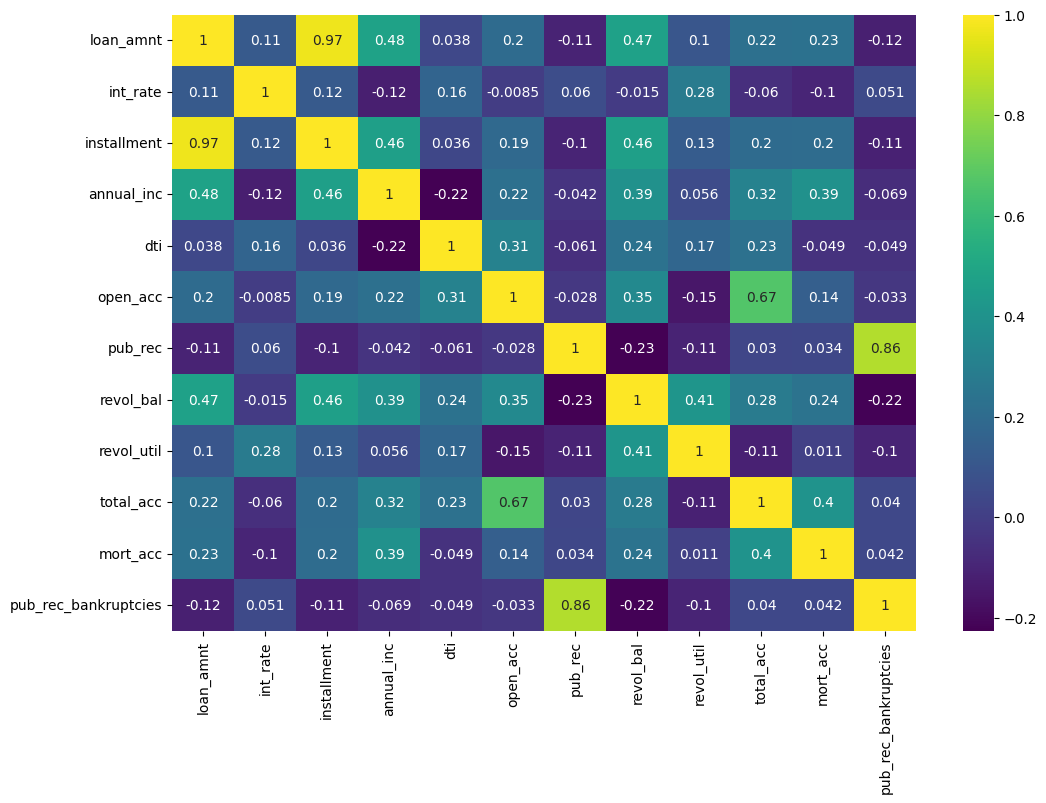

In [34]:
plt.figure(figsize=(12,8))
sns.heatmap(df_float.corr(method='spearman'),annot=True,cmap='viridis')
plt.show()

In [35]:
df.drop(columns=['installment'],axis=1,inplace=True)
df_float.drop(columns=['installment'],axis=1,inplace=True)

C:\Users\Rhythm Shah\AppData\Local\Temp\ipykernel_7208\546979441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_float.drop(columns=['installment'],axis=1,inplace=True)


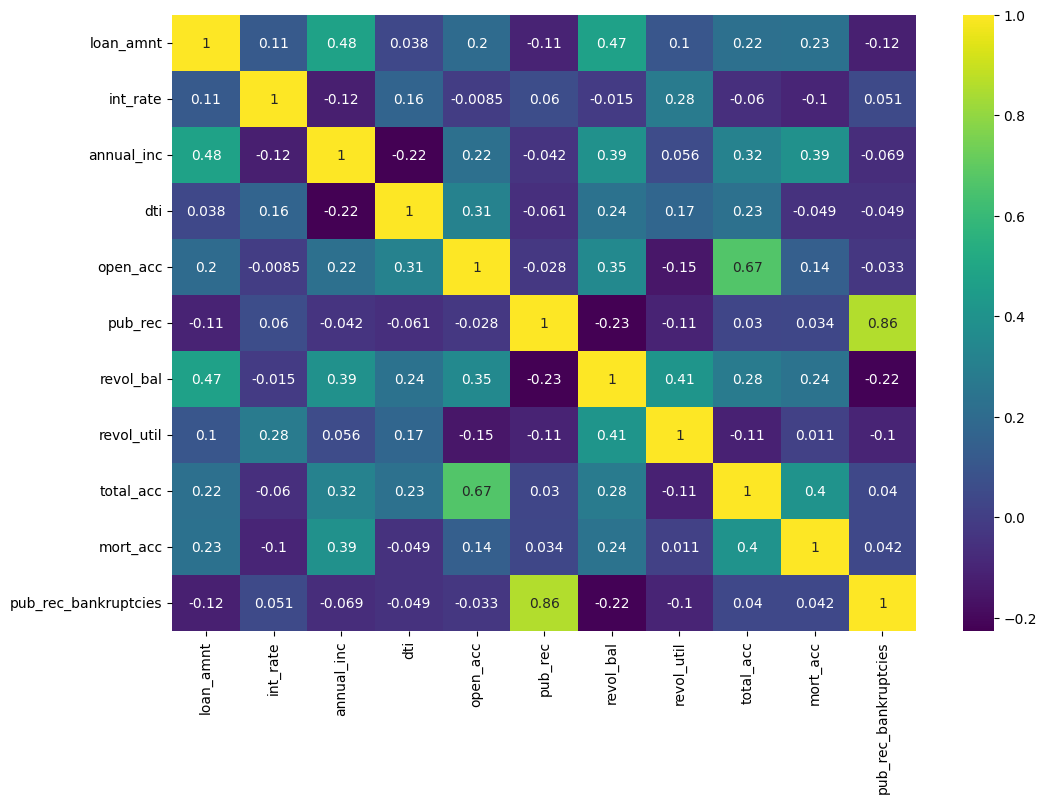

In [36]:
plt.figure(figsize=(12,8))
sns.heatmap(df_float.corr(method='spearman'),annot=True,cmap='viridis')
plt.show()

3. The majority of people have home ownership as _______.

In [38]:
df ['home_ownership'].value_counts(normalize=True)*100

home_ownership
MORTGAGE    50.862693
RENT        39.876499
OWN          9.243242
OTHER        0.008932
NONE         0.008337
ANY          0.000298
Name: proportion, dtype: float64

In [40]:
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    170831
RENT        133932
OWN          31045
OTHER           30
NONE            28
ANY              1
Name: count, dtype: int64

4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)